In [1]:
import pandas as pd

import example_parameters
from model import *
from parameters import Parameters

import numpy as np
import matplotlib.pyplot as plt

from da_utils import EnsembleKalmanFilter
from da_utils import GenerateEnsemble
from da_utils import Visualization

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
def normalize_array(array):
    max_ = max(array)
    if max_ == 0:
        return array
    return [x / max_ for x in array]


def compute_for_visualization(parameters, simulation_len, epsilon, normalize=True):
    xc, xe, y, w, am, aM, bc, be, s, gamma, lambda_, kappa, delta, rho = parameters.unpacked()

    xcs, xes, ys, ws = [xc], [xe], [y], [w]

    for i in range(int(simulation_len / epsilon)):
        xc, xe, y, w = step(xc, xe, y, w, am, aM, bc, be, s, gamma, lambda_, kappa, delta, rho, epsilon)
        xcs.append(xc)
        xes.append(xe)
        ys.append(y)
        ws.append(w)

    return xcs, xes, ys, ws


def plot(xcs, xes, ys, ws):
    plt.plot(xcs, label="Common people")
    plt.plot(xes, label="Elite population")
    plt.plot(ys, label="Nature")
    plt.plot(ws, label="Accumulated wealth")
    plt.legend()
    plt.show()

11187.969667447607 2082.477034548391 1.4143263769761627 12.902115437300195
11960.363239070502 13246.751149268224 100 145.53393319195158


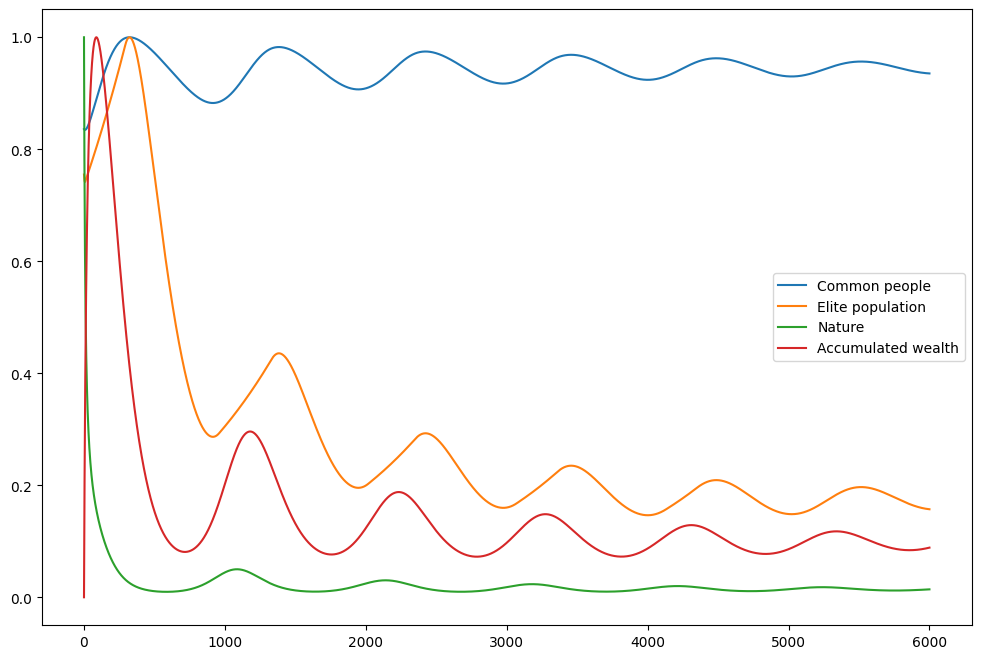

In [3]:
params = example_parameters.elite_equilibrium
simulation_len = params.simulation_len
epsilon = params.epsilon

xcs, xes, ys, ws = compute_for_visualization(params, simulation_len, epsilon)
print(xcs[-1], xes[-1], ys[-1], ws[-1])
print(max(xcs), max(xes), max(ys), max(ws))

normalize = True
if normalize:
    xcsn = normalize_array(xcs)
    xesn = normalize_array(xes)
    ysn = normalize_array(ys)
    wsn = normalize_array(ws)

# plot(xcs, xes, ys, ws)
plot(xcsn, xesn, ysn, wsn)

In [4]:
print([x[0] for x in (xcs, xes, ys, ws)])
print([x[1] for x in (xcs, xes, ys, ws)])
print([x[2] for x in (xcs, xes, ys, ws)])


[10000, 10000, 100, 0]
[9995.0, 9950.0, 91.28, 8.720000000000002]
[9990.957682245764, 9909.758817754235, 84.120325408, 16.588436192000003]


In [5]:
def _elite_equilibrium2():
    # metaparameters
    # oscylacja do stałej
    simulation_len = 600
    epsilon = .1

    # constants
    am, aM = 0.01, 0.06  # normal and famine death rates
    bc, be = 0.06, 0.016  # commoner and elite birth rate
    s, rho = 6e-4, 6e-3  # Subsistence salary per capita, Threshold wealth per capita
    gamma, lambda_ = 0.011, 110  # nature regeneration rate, nature carrying capacity
    kappa, delta = 11, 8e-5  # inequality factor, depletion(production) factor

    # variables
    xc, xe, y, w = 10000, 10000, lambda_, 0  # commoner pop, elite pop, nature, accumulated wealth

    return Parameters(simulation_len, epsilon, am, aM, bc, be, s, rho, gamma, lambda_, kappa, delta, xc, xe, y, w)


elite_equilibrium2 = _elite_equilibrium2()

17674.199120606718 6.16450817783028e-07 1.3877596571805446e-49 7.613263280140293e-23
17674.199120606718 12844.740136839933 110 242.86501976599368


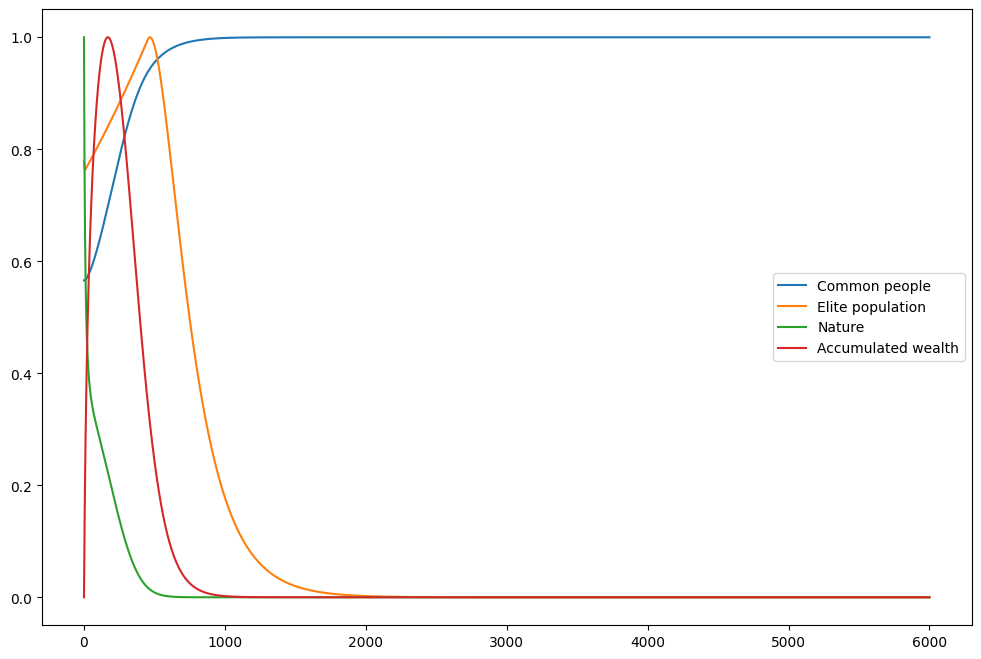

In [6]:
params = elite_equilibrium2
simulation_len = params.simulation_len
epsilon = params.epsilon

xcs, xes, ys, ws = compute_for_visualization(params, simulation_len, epsilon)
print(xcs[-1], xes[-1], ys[-1], ws[-1])
print(max(xcs), max(xes), max(ys), max(ws))

normalize = True
if normalize:
    xcs = normalize_array(xcs)
    xes = normalize_array(xes)
    ys = normalize_array(ys)
    ws = normalize_array(ws)

plot(xcs, xes, ys, ws)

In [7]:
class HandyModel:
    def __init__(self, xc, xe, y, w, noise, params):
        # self.params = params
        self.noise = noise
        self.simulation_len = params.simulation_len
        self.epsilon = params.epsilon

        _, _, _, _, self.am, self.aM, self.bc, self.be, self.s, self.gamma, self.lambda_, self.kappa, self.delta, self.rho = params.unpacked()
        self.xc, self.xe, self.y, self.w = xc, xe, y, w

    def time_integration(self):
        self.xc, self.xe, self.y, self.w = step(self.xc, self.xe, self.y, self.w, self.am, self.aM, self.bc, self.be, self.s, self.gamma, self.lambda_, self.kappa, self.delta,
                                                self.rho, self.epsilon)

        return self.xc, self.xe, self.y, self.w

    def observation_noise(self):
        self.xc = self.xc + np.random.normal(0, self.noise)
        self.xe = self.xe  #+ np.random.normal(0,self.noise)
        self.y = self.y  #+ np.random.normal(0,self.noise)
        self.w = self.w  #+ np.random.normal(0,self.noise)

        return self.xc, self.xe, self.y, self.w

In [8]:
#time step
length = 6000

#Observation noise
noise = 150  #standard deviation

#Initial condition
xct = example_parameters.elite_equilibrium.xc
xet = example_parameters.elite_equilibrium.xe
yt = example_parameters.elite_equilibrium.y
wt = example_parameters.elite_equilibrium.w  # #True

xcsf = elite_equilibrium2.xc
xesf = elite_equilibrium2.xe
ysf = elite_equilibrium2.y
wsf = elite_equilibrium2.w  #Simulation

#For Visuallization
xctrue, xetrue, ytrue, wtrue = [xct], [xet], [yt], [wt]  #True for visualization
xcobs, xeobs, yobs, wobs = [xct], [xet], [yt], [wt]  #Observation for visualization
xcsim, xesim, ysim, wsim = [xcsf], [xesf], [ysf], [wsf]  #Simulation for visualization

xcs, xes, ys, ws = xcsf, xesf, ysf, wsf

for t in range(length):
    #True,Observation and Simulation
    model = HandyModel(xct, xet, yt, wt, noise, example_parameters.elite_equilibrium)
    xct, xet, yt, wt = model.time_integration()
    xco, xeo, yo, wo = model.observation_noise()

    #Simulation
    model = HandyModel(xcs, xes, ys, ws, noise, elite_equilibrium2)
    xcs, xes, ys, ws = model.time_integration()

    #visualization
    xctrue.append(xct)
    xetrue.append(xet)
    ytrue.append(yt)
    wtrue.append(wt)

    xcobs.append(xco)
    xeobs.append(xeo)
    yobs.append(yo)
    wobs.append(wo)

    xcsim.append(xcs)
    xesim.append(xes)
    ysim.append(ys)
    wsim.append(ws)

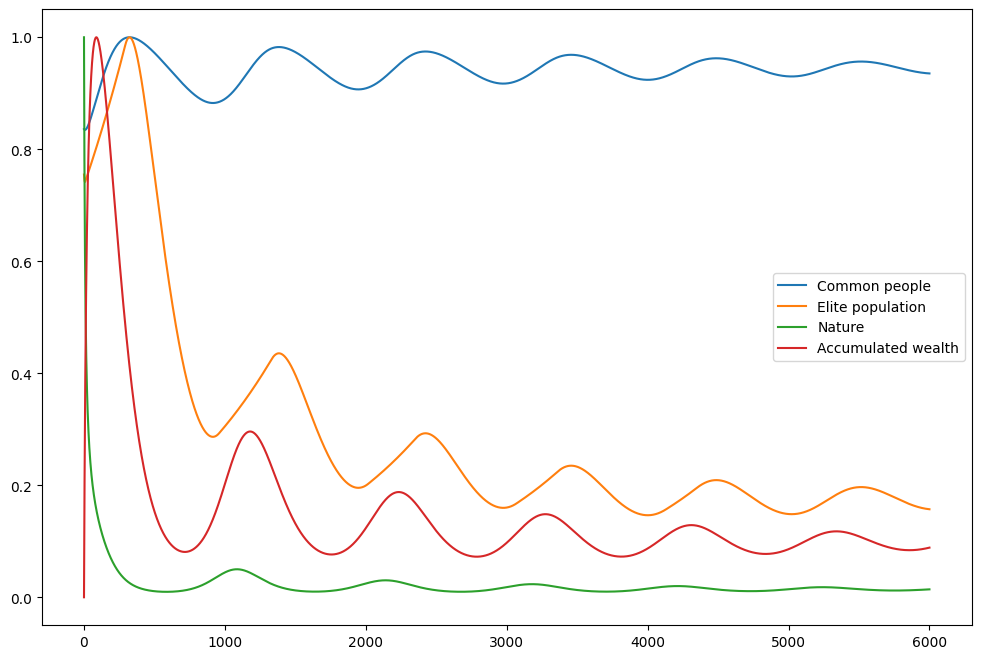

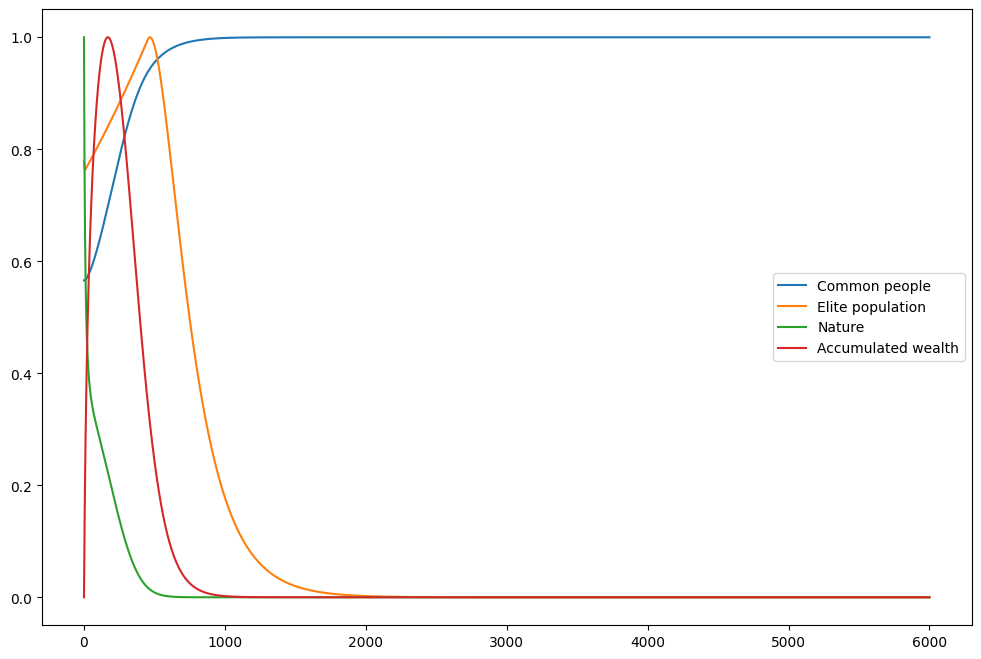

In [9]:
(xcsimn, xesimn, ysimn, wsimn) = [normalize_array(x) for x in (xcsim, xesim, ysim, wsim)]
(xctruen, xetruen, ytruen, wtruen) = [normalize_array(x) for x in (xctrue, xetrue, ytrue, wtrue)]

# plot(xctrue,xetrue,ytrue,wtrue)
# plot(xcobs,xeobs,yobs,wobs)
# plot(xcsim,xesim,ysim,wsim)
plot(xctruen, xetruen, ytruen, wtruen)
plot(xcsimn, xesimn, ysimn, wsimn)

In [13]:
def train(obs_interval=100, nens=100, initial_noise=4.0, ratio=0.5, math_mode = False):
    nt_asm = int(length * ratio)

    H = np.array([1, 0, 0, 0]).reshape(1, 4)  # Observation only in x
    #H = np.array([1,0,0], [0,1,0]) # Observation in x and y
    #H = np.array([[1,0,0],[0,1,0],[0,0,1]]) # Observation in x,y and z

    xcda, xeda, yda, wda = [xcsf], [xesf], [ysf], [wsf]
    xcs, xes, ys, ws = xcsf, xesf, ysf, wsf  #simulation
    xyzsim = np.array([xcs, xes, ys, ws])
    xcsim2, xesim2, ysim2, wsim2 = [xcs], [xes], [ys], [ws]

    #initial ensemble generation
    generate = GenerateEnsemble.GenerateEnsemble(xyzsim, nens, initial_noise)
    ensemble = generate.fit()
    for t in range(length):
        #Data Assimilation
        for ens in range(nens):
            lorenz = HandyModel(ensemble[ens, 0], ensemble[ens, 1], ensemble[ens, 2], ensemble[ens, 3], noise, example_parameters.elite_equilibrium)
            ensemble[ens, 0], ensemble[ens, 1], ensemble[ens, 2], ensemble[ens, 3] = lorenz.time_integration()

        if np.mod(t, obs_interval) == 0 and nt_asm > t > 0:
            xecxywobs = np.array([xcobs[t], xeobs[t], yobs[t], wobs[t]])
            enkf = EnsembleKalmanFilter.EnsembleKalmanFilter(ensemble, H, xecxywobs, noise)
            update = enkf.fit()
            ensemble = ensemble + update

        xcda.append(ensemble[:, 0].mean())
        xeda.append(ensemble[:, 1].mean())
        yda.append(ensemble[:, 2].mean())
        wda.append(ensemble[:, 3].mean())

        if t == nt_asm:  # start new simulation
            xcsf2, xesf2, ysf2, wsf2 = xctrue[t], xetrue[t], ytrue[t], wtrue[t]
        if t > nt_asm:  #second simulaion:
            model = HandyModel(xcsf2, xesf2, ysf2, wsf2, noise, elite_equilibrium2)
            xcsf2, xesf2, ysf2, wsf2 = model.time_integration()
            xcsim2.append(xcsf2)
            xesim2.append(xesf2)
            ysim2.append(ysf2)
            wsim2.append(wsf2)
        else:
            xcsim2.append(xctrue[t])
            xesim2.append(xetrue[t])
            ysim2.append(ytrue[t])
            wsim2.append(wtrue[t])
            # xcsim2.append(0)
            # xesim2.append(0)
            # ysim2.append(0)
            # wsim2.append(0)

    if not math_mode:
        vis = Visualization.Visualization(xcobs, xctrue, xcsim, xcsim2, xcda, obs_interval, nt_asm, 'xc', 6000).fit()
        vis2 = Visualization.Visualization(None, xetrue, xesim, xesim2, xeda, obs_interval, nt_asm, 'xe', 6000).fit()
        vis3 = Visualization.Visualization(None, ytrue, ysim, ysim2, yda, obs_interval, nt_asm, 'y', 6000).fit()
        vis4 = Visualization.Visualization(None, wtrue, wsim, wsim2, wda, obs_interval, nt_asm, 'w', 6000).fit()

        # vis.plot_rmse()
        # vis2.plot_rmse()
        # vis3.plot_rmse()
        # vis4.plot_rmse()
    else:
        vis = Visualization.Visualization(xcobs, xctrue, xcsim, xcsim2, xcda, obs_interval, nt_asm, 'xx', 6000)
        vis2 = Visualization.Visualization(None, xetrue, xesim, xesim2, xeda, obs_interval, nt_asm, 'xe', 6000)
        vis3 = Visualization.Visualization(None, ytrue, ysim, ysim2, yda, obs_interval, nt_asm, 'y', 6000)
        vis4 = Visualization.Visualization(None, wtrue, wsim, wsim2, wda, obs_interval, nt_asm, 'w', 6000)
        return vis.get_rmse(nt_asm, nt_asm+3000), vis2.get_rmse(nt_asm, nt_asm+3000), vis3.get_rmse(nt_asm, nt_asm+3000), vis4.get_rmse(nt_asm, nt_asm+3000)


    # plot(xcsim2, xesim2, ysim2, wsim2)


# train(ratio=0.5)
# train(ratio=0.1, obs_interval=20)
# train(ratio=0.1)



In [14]:
tables1 = [train(math_mode=True) for _ in range(10)]
tables1a = np.asarray(tables1)
avg_table1 = np.average(tables1a, axis=0).T
df1 = pd.DataFrame(avg_table1, columns = ['Commons','Elites','Nature', 'Acc wealth'])
df1.index = ['DA', 'Simulation', 'Simulation 2']
df1

,Commons,Elites,Nature,Acc wealth
DA,111.109367,195.851131,0.112596,0.928610
Simulation,6371.958550,2425.769196,1.553411,15.221070
Simulation 2,10515.655967,1952.190122,3.544265,29.391908


In [15]:
tables2 = [train(ratio=0.1, obs_interval=20, math_mode=True) for _ in range(10)]
tables2a = np.asarray(tables2)
avg_table2 = np.average(tables2a, axis=0).T
df2 = pd.DataFrame(avg_table2, columns = ['Commons','Elites','Nature', 'Acc wealth'])
df2.index = ['DA', 'Simulation', 'Simulation 2']
df2

,Commons,Elites,Nature,Acc wealth
DA,85.257906,326.315191,0.148294,1.259601
Simulation,6432.339789,3184.626775,2.278383,21.276483
Simulation 2,6832.457798,2681.143918,4.677321,40.099202


In [16]:
tables3 = [train(ratio=0.1, math_mode=True) for _ in range(10)]
tables3a = np.asarray(tables3)
avg_table3 = np.average(tables3a, axis=0).T
df3 = pd.DataFrame(avg_table3, columns = ['Commons','Elites','Nature', 'Acc wealth'])
df3.index = ['DA', 'Simulation', 'Simulation 2']
df3

,Commons,Elites,Nature,Acc wealth
DA,200.069623,662.736077,0.298756,2.556759
Simulation,6432.339789,3184.626775,2.278383,21.276483
Simulation 2,6832.457798,2681.143918,4.677321,40.099202


In [17]:
das = [avg_table1[0], avg_table2[0], avg_table3[0]]

In [18]:
df = pd.DataFrame(das, columns=['Commons', 'Elites', 'Nature', 'Acc wealth'])
df.index = ['50%', '10%, 5x dense', '10%']
df

,Commons,Elites,Nature,Acc wealth
50%,111.109367,195.851131,0.112596,0.928610
"10%, 5x dense",85.257906,326.315191,0.148294,1.259601
10%,200.069623,662.736077,0.298756,2.556759
